<a href="https://colab.research.google.com/github/Laura-VFA/MachineLearning-21-22/blob/main/ML_Deliverable2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Laura Villa Fernández-Arroyo
- Sergio Martínez Cid
- David González Bermúdez

# Machine Learning Techniques - Deliverable 2: Text Classification

First, all the needed libraries and the data will be loaded.

In [1]:
!rm *.*

!wget https://raw.githubusercontent.com/Laura-VFA/MachineLearning-21-22/main/Datasets/comments.csv


--2022-01-07 19:29:33--  https://raw.githubusercontent.com/Laura-VFA/MachineLearning-21-22/main/Datasets/comments.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1690905 (1.6M) [text/plain]
Saving to: ‘comments.csv’

comments.csv        100%[===================>]   1.61M  --.-KB/s    in 0.05s   

2022-01-07 19:29:33 (29.6 MB/s) - ‘comments.csv’ saved [1690905/1690905]



In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import groupby
import matplotlib.pyplot as plt

import nltk
nltk.download("popular")
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn import model_selection, svm, tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from scipy.stats import randint as sp_randint


!pip install stanza
import stanza

!pip install textblob
from textblob import TextBlob

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [3]:
comments = pd.read_csv('comments.csv', sep=',')
comments.head()

,class,text
0,Auto,I have recently purchased a J30T with moderat...
1,Camera,I bought this product because I need instant ...
2,Auto,I have owned my Buick since 53000 km and I am...
3,Camera,This was my first Digital camera so I did qui...
4,Camera,Minolta DiMAGE 7Hi is in a digital SLR with 5...


# 1. Preprocessing

## 1.1 Remove useless data

Remove characters such us $, @...

In [4]:
pattern = "!|\"|_|-|$|%|&|\/|\(|\)|=|ˆ|\*|¡|@" 
comments['text'] = [ re.sub(pattern, "", text) for text in comments['text']]

## 1.2 Remove all capital letters

In [5]:
comments['text'] = [text.lower() for text in comments['text']]

In [6]:
comments['text']

0       i have recently purchased a j30t with moderat...
1       i bought this product because i need instant ...
2       i have owned my buick since 53000 km and i am...
3       this was my first digital camera so i did qui...
4       minolta dimage 7hi is in a digital slr with 5...
                             ...                        
595     recently our 12 year old nissan stanza decide...
596     i always do a lot of research before i buy an...
597     this car is an all around good buy  if you ar...
598     i waited to write this until i have had 4 mon...
599     i have been a montero owner since about 1985 ...
Name: text, Length: 600, dtype: object

## 1.3 Remove contractions

Regular expressions will be used for this purpose. The patterns found will be replaced by its not contracted version.  
However, there are situations in which there's a conflict between removal contraction posibilities: for example, *I'd* could be referred to *I would* or *I had*. This conflict could be solved with the word context analysis, but it's out of the scope of this project.

In [7]:
# Contractions detection 
patrones=[  # (patron/regex, not_contracted)
(r'that\s*?\'?\s*s','that is'),   
(r'won\s*\'?\s*t','will not'),   #won't
(r'can\s*\'?\s*t','cannot'),     #can't
(r'i\s*\'?\s*m','i am'),         # I'm
(r'ain\s*\'?\s*t', 'is not'),     # ain't
]

for word in ['he', 'I', 'it', 'she', 'they', 'we', 'who', 'you']:
    patrones.append((r'\b' + word + r'\s*\'?\s*ll', word +' will'))

for word in ['are', 'could', 'did', 'do', 'does', 'had', 'have', 'should', 'was', 'were', 'is', 'would', 'must']:
    patrones.append((r'\b' + word + r'\s*n\'?\s*t', word +' not'))

for word in ['you', 'I', 'we', 'they']:
    patrones.append((r'\b' + word + r'\s*\'?\s*ve', word +' have'))

for word in ['that' , 'there', 'he', 'here', 'what', 'where', 'who', 'it', 'she']:
    patrones.append((r'\b' + word + r'\s*\'?\s*s', word +' is'))

for word in ['you', 'we', 'they',]:
    patrones.append((r'\b' + word + r'\s*\'?\s*re', word +' are'))

for word in ['she', 'they', 'he', 'we', 'I', 'you',]:
    patrones.append((r'\b' + word + r'\s*\'?\s*d', word +' would'))

for word in ['she', 'he', 'it']:
    patrones.append((r'\b' + word + r'\s*\'?\s*s', word +' has'))
  
for word in ['she', 'they', 'he', 'we', 'I', 'you',]:
    patrones.append((r'\b' + word + r'\s*\'?\s*d', word +' had'))

for (patron, no_contraido) in patrones: 
  comments['text'] = [re.sub(patron, no_contraido, sentence) for sentence in comments['text']]

comments['text'][0]

' i have recently purchased a j30t with moderate miles  i shopped for a car that was looked after and paid more for it  as a former auto technician i know what to look for and what to expect yet every ti ame i drive this car i say to my self  dam that is a great car   and yes i truly do  the car affords a level of style and comfort that is beyond compare for the price  i had looked at a number of j30 s with some having covered 160k miles   i checked them to see where the problems show  they we are great other than just basic owner neglect the car is extremely quiet and smooth yet does not distance it iself from a mild degree of sportiness  performance is smooth yet i ampressive yet the power is we will handled by braking and suspension systems of si amilar refinement the appointments available with the car we are somewhat sparse yet the standard of quality and functionality we are apparent  the bose sound system for example has remarkable output and clarity without all the fancy dials 

## 1.4 Correct wrong words

TextBlob will be used for correct wrong written words.

In [8]:
comments['text'] = [str(TextBlob(comment).correct()) for comment in comments['text']]

comments['text'][0]

' i have recently purchased a just with moderate miles  i stopped for a car that was looked after and paid more for it  as a former auto technical i know what to look for and what to expect yet every ti ame i drive this car i say to my self  dam that is a great car   and yes i truly do  the car affords a level of style and comfort that is beyond compare for the price  i had looked at a number of j s with some having covered 160k miles   i checked them to see where the problems show  they we are great other than just basic owner neglect the car is extremely quiet and smooth yet does not distance it itself from a mild degree of shortness  performance is smooth yet i impressive yet the power is we will handled by breaking and suspension systems of si similar refinement the appointments available with the car we are somewhat spare yet the standard of quality and functionality we are apparent  the bone sound system for example has remarkable output and clarity without all the fancy deals  m

## 1.5 Remove or replace emoticons

Regular expressions will be used again. In this case, cameras, hearts, cars and smiles will be replaced by the words *camera*, *love*, *car* and *smile*, respectively. The remainder emoticons will be deleted.

In [9]:
pattern_camera = u'[\ud83d\udcf7\ud83c]'
pattern_love = u'[\u2764\ufe0f\U0001f496\u2665\ufe0f\U0001f495\U0001f493\u2661\u2665\ufe0f\U0001f618]'
pattern_car = u'[\U0001f697\U0001f698\U0001f6fb\U0001f3ce\U0001f699]'
pattern_smile = u'[\U0001f60a\U0001f600]'
comments['text'] = [ re.sub(pattern_camera, "camera", text) for text in comments['text'] ]
comments['text'] = [ re.sub(pattern_love, "love", text) for text in comments['text'] ]
comments['text'] = [ re.sub(pattern_car, "car", text) for text in comments['text'] ]
comments['text'] = [ re.sub(pattern_smile, "smile", text) for text in comments['text'] ]

pattern_emotic = u'[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FA\u260E-\u26FF-\u2700-\u27BF]'
comments['text'] = [ re.sub(pattern_emotic, "", text) for text in comments['text'] ]


## 1.6 Remove repeated words

For this step, list of words will be used for recognizing sequential repeated words. Thus, the comments will be tokenized by words. Then, a *groupby* function will be used for grouping them, taking only the first instance.

In [10]:
comments['text'] = [word_tokenize(sentence) for sentence in comments['text']]
comments['text']

0      [i, have, recently, purchased, a, just, with, ...
1      [i, bought, this, product, because, i, need, i...
2      [i, have, owned, my, quick, since, 53000, km, ...
3      [this, was, my, first, digital, camera, so, i,...
4      [minorca, di, damage, hi, is, in, a, digital, ...
                             ...                        
595    [recently, our, 12, year, old, nissan, stanza,...
596    [i, always, do, a, lot, of, research, before, ...
597    [this, car, is, an, all, around, good, buy, if...
598    [i, waited, to, write, this, until, i, have, h...
599    [i, have, been, a, monster, owner, since, abou...
Name: text, Length: 600, dtype: object

In [11]:
comments['text'] = [list(map(lambda word: word[0], groupby(comment))) for comment in comments['text']]

## 1.7 Lemmatize all terms



For this step, each category will be lemmatized, using *WordNetLemmatizer*.

In [12]:
lemmatizer = WordNetLemmatizer()
comments['text'] = [[lemmatizer.lemmatize(word, pos = 'n') for word in sentence] for sentence in comments['text']]
comments['text'] = [[lemmatizer.lemmatize(word, pos = 'v') for word in sentence] for sentence in comments['text']]
comments['text'] = [[lemmatizer.lemmatize(word, pos = 'a') for word in sentence] for sentence in comments['text']]
comments['text'] = [[lemmatizer.lemmatize(word, pos = 'r') for word in sentence] for sentence in comments['text']]
comments['text'] = [[lemmatizer.lemmatize(word, pos = 's') for word in sentence] for sentence in comments['text']]
comments['text']

0      [i, have, recently, purchase, a, just, with, m...
1      [i, buy, this, product, because, i, need, inst...
2      [i, have, own, my, quick, since, 53000, km, an...
3      [this, wa, my, first, digital, camera, so, i, ...
4      [minorca, di, damage, hi, be, in, a, digital, ...
                             ...                        
595    [recently, our, 12, year, old, nissan, stanza,...
596    [i, always, do, a, lot, of, research, before, ...
597    [this, car, be, an, all, around, good, buy, if...
598    [i, wait, to, write, this, until, i, have, hav...
599    [i, have, be, a, monster, owner, since, about,...
Name: text, Length: 600, dtype: object

Finally, comments will be transformed into strings, as previously.

In [13]:
comments['text'] = [' '.join(comment) for comment in comments['text'] ]
comments['text']

0      i have recently purchase a just with moderate ...
1      i buy this product because i need instant grat...
2      i have own my quick since 53000 km and i be no...
3      this wa my first digital camera so i do quite ...
4      minorca di damage hi be in a digital sir with ...
                             ...                        
595    recently our 12 year old nissan stanza decide ...
596    i always do a lot of research before i buy any...
597    this car be an all around good buy if you be i...
598    i wait to write this until i have have 4 month...
599    i have be a monster owner since about 1985 and...
Name: text, Length: 600, dtype: object

#2. Vectorization

Every comment will be vectorized with several configurations, each with increasing complexity.

## 2.1 TFIDF

In [14]:
vectorizer_tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True)

# Fit and transform
data_tfidf = vectorizer_tfidf.fit_transform(comments['text'])

In [15]:
# Create a dataframe for visualization
cv_tfidf=pd.DataFrame(data_tfidf.toarray(), columns=vectorizer_tfidf.get_feature_names())
print(cv_tfidf)

          00  000   01   02  024  ...  ziebart  zip  zone  zoombrowser  zum
0    0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
1    0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
2    0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
3    0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
4    0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
..       ...  ...  ...  ...  ...  ...      ...  ...   ...          ...  ...
595  0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
596  0.06697  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
597  0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
598  0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0
599  0.00000  0.0  0.0  0.0  0.0  ...      0.0  0.0   0.0          0.0  0.0

[600 rows x 7870 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 2.2 TFIDF + N-grams

In [16]:
vectorizer_ngrams = TfidfVectorizer(ngram_range=(1,3))

# Fit and transform
data_ngrams = vectorizer_ngrams.fit_transform(comments['text'])
print("vocabulary: ", vectorizer_ngrams.vocabulary_)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
# Create a Dataframe
cv_tfidf_ngrams=pd.DataFrame(data_ngrams.toarray(),columns=vectorizer_ngrams.get_feature_names())
print(cv_tfidf_ngrams)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


           00  00 00  00 00 from  ...  zum consider it  zum this  zum this car
0    0.000000    0.0         0.0  ...              0.0       0.0           0.0
1    0.000000    0.0         0.0  ...              0.0       0.0           0.0
2    0.000000    0.0         0.0  ...              0.0       0.0           0.0
3    0.000000    0.0         0.0  ...              0.0       0.0           0.0
4    0.000000    0.0         0.0  ...              0.0       0.0           0.0
..        ...    ...         ...  ...              ...       ...           ...
595  0.000000    0.0         0.0  ...              0.0       0.0           0.0
596  0.025144    0.0         0.0  ...              0.0       0.0           0.0
597  0.000000    0.0         0.0  ...              0.0       0.0           0.0
598  0.000000    0.0         0.0  ...              0.0       0.0           0.0
599  0.000000    0.0         0.0  ...              0.0       0.0           0.0

[600 rows x 341119 columns]


## 2.3 TFIDF + N-grams + POS tagging

For POS tagging it's necessary to tokenize by words again. This tokenization will be stored in a new column *text_token*.

In [18]:
# Word tokenization
comments['text_token'] = [word_tokenize(sentence) for sentence in comments['text']]
comments['text_token']

0      [i, have, recently, purchase, a, just, with, m...
1      [i, buy, this, product, because, i, need, inst...
2      [i, have, own, my, quick, since, 53000, km, an...
3      [this, wa, my, first, digital, camera, so, i, ...
4      [minorca, di, damage, hi, be, in, a, digital, ...
                             ...                        
595    [recently, our, 12, year, old, nissan, stanza,...
596    [i, always, do, a, lot, of, research, before, ...
597    [this, car, be, an, all, around, good, buy, if...
598    [i, wait, to, write, this, until, i, have, hav...
599    [i, have, be, a, monster, owner, since, about,...
Name: text_token, Length: 600, dtype: object

The POS tagging of each word will have the format <*word_pos*>. They will be stored in the list *pos_comments*.

In [19]:
pos_comments = [[f'{word_pos[0]}_{word_pos[1]}' for word_pos in nltk.pos_tag(comment)] for comment in comments['text_token']]

Then, the POS tagged words will be joined in string format. Finally, they will be stored in *comments* dataset.

In [20]:
comments['pos_comments'] = [' '.join(comment) for comment in pos_comments]

In [21]:
comments.head()

,class,text,text_token,pos_comments
0,Auto,i have recently purchase a just with moderate ...,"[i, have, recently, purchase, a, just, with, m...",i_NNS have_VBP recently_RB purchase_VB a_DT ju...
1,Camera,i buy this product because i need instant grat...,"[i, buy, this, product, because, i, need, inst...",i_JJ buy_VBP this_DT product_NN because_IN i_J...
2,Auto,i have own my quick since 53000 km and i be no...,"[i, have, own, my, quick, since, 53000, km, an...",i_NNS have_VBP own_JJ my_PRP$ quick_JJ since_I...
3,Camera,this wa my first digital camera so i do quite ...,"[this, wa, my, first, digital, camera, so, i, ...",this_DT wa_NN my_PRP$ first_JJ digital_JJ came...
4,Camera,minorca di damage hi be in a digital sir with ...,"[minorca, di, damage, hi, be, in, a, digital, ...",minorca_NN di_NN damage_NN hi_NN be_VB in_IN a...


Now, vectorization will be applied to this new colum.

In [22]:
vectorizer_ngrams_pos = TfidfVectorizer(ngram_range=(1,3))

# Fit and transform
data_ngrams_pos = vectorizer_ngrams_pos.fit_transform(comments['pos_comments'])
print("vocabulary: ", vectorizer_ngrams_pos.vocabulary_)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
# Creation of Dataframe for visualization
cv_tfidf_ngrams_pos=pd.DataFrame(data_ngrams_pos.toarray(),columns=vectorizer_ngrams_pos.get_feature_names())
print(cv_tfidf_ngrams_pos)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


     000_cd  000_cd 00_cd  ...  zum_nn this_dt  zum_nn this_dt car_nn
0       0.0           0.0  ...             0.0                    0.0
1       0.0           0.0  ...             0.0                    0.0
2       0.0           0.0  ...             0.0                    0.0
3       0.0           0.0  ...             0.0                    0.0
4       0.0           0.0  ...             0.0                    0.0
..      ...           ...  ...             ...                    ...
595     0.0           0.0  ...             0.0                    0.0
596     0.0           0.0  ...             0.0                    0.0
597     0.0           0.0  ...             0.0                    0.0
598     0.0           0.0  ...             0.0                    0.0
599     0.0           0.0  ...             0.0                    0.0

[600 rows x 380447 columns]


## 2.4 TFIDF + N-grams + POS tagging + other features

In this final step, the number of words per comment will be included to the previous dataframe as new feature.

In [24]:
cv_tfidf_ngrams_pos_other = cv_tfidf_ngrams_pos.copy(deep=True)
cv_tfidf_ngrams_pos_other['n_words'] = [len(comment) for comment in comments['text_token']]

In [25]:
cv_tfidf_ngrams_pos_other['n_words']

0       230
1       535
2       281
3       201
4      1000
       ... 
595     409
596     341
597     160
598     467
599     248
Name: n_words, Length: 600, dtype: int64

# 3. Feature selection & Classification

This will be applied to each vectorization configuration in order to compare the results.  
Using *selectKBest*, 70% of the features will be removed.  
Before applying any classification algorithm, train and test data split must be carried out. 70% of the dataset will be used for training and 30% for testing. Support Vector Machine and Random Forests algorithms will be applied for solving this problem. Hyperparameter optimization and cross-validation will be carried out.

## 3.1 TFIDF

### 3.1.1 Feature selection

In [26]:
# Create feature and target variable for Classification problem
X_clf = cv_tfidf

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

print(y_clf)

[0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0
 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0
 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1
 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0
 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0
 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0
 1 1 0 1 0 0 1 0 1 0 1 0 

In [27]:
X_clf_new=SelectKBest(score_func=chi2,k=int(X_clf.shape[1] * .3)).fit_transform(X_clf,y_clf) # k is the 30% of the features number

# Check the newly created variable shape
print(X_clf_new.shape)

(600, 2361)


### 3.1.2 Classification algorithm

In [28]:
X_clf_new = pd.DataFrame(X_clf_new)

x_features = list(X_clf_new.columns)
len(x_features)

2361

In [29]:
X = X_clf_new[x_features]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

#### 3.1.2.1 SVM

In [30]:
# Hyperparameter optimization
param_dist = {
              'kernel': ['linear', 'rbf'],
             }
SVM = GridSearchCV(estimator = svm.SVC(), param_grid = param_dist, 
                   cv = 2, n_jobs = -1) # SVM model definition

SVM.fit(X_train, y_train) # Training

GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'kernel': ['linear', 'rbf']})

In [31]:
y_pred = SVM.predict(X_test) # Prediction

print(X_test)
print(y_pred)

         0         1     2     3     ...      2357      2358  2359  2360
110  0.000000  0.000000   0.0   0.0  ...  0.000000  0.087621   0.0   0.0
419  0.000000  0.000000   0.0   0.0  ...  0.000000  0.000000   0.0   0.0
565  0.000000  0.000000   0.0   0.0  ...  0.000000  0.000000   0.0   0.0
77   0.000000  0.030754   0.0   0.0  ...  0.000000  0.000000   0.0   0.0
181  0.049812  0.000000   0.0   0.0  ...  0.043266  0.000000   0.0   0.0
..        ...       ...   ...   ...  ...       ...       ...   ...   ...
54   0.000000  0.000000   0.0   0.0  ...  0.000000  0.000000   0.0   0.0
493  0.000000  0.015582   0.0   0.0  ...  0.000000  0.000000   0.0   0.0
46   0.000000  0.000000   0.0   0.0  ...  0.022831  0.000000   0.0   0.0
93   0.000000  0.000000   0.0   0.0  ...  0.000000  0.000000   0.0   0.0
264  0.000000  0.000000   0.0   0.0  ...  0.000000  0.000000   0.0   0.0

[180 rows x 2361 columns]
[1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0
 1 1 1 0 0 1 0 0 1 0 1

For a correct result visualization, confusion matrix will be plotted. Also the *Precision*, *Recall* and *F-measure* will be calculated.




[[ 77   0]
 [  0 103]]


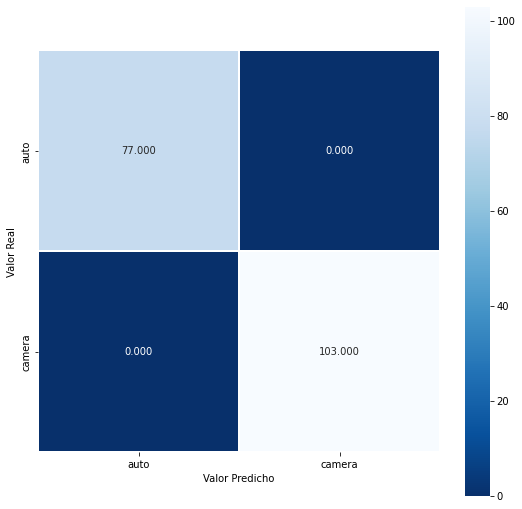

In [32]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels = ["auto", "camera"], xticklabels = ["auto", "camera"]);
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');

In [33]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_measure = 2 /(1/precision+1/recall)
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F-measure = " + str(F_measure))

Precision = 1.0
Recall = 1.0
F-measure = 1.0


#### 3.1.2.2 RandomForests

In [34]:
# Hyperparameter optimization
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_depth": [16, 15, 14, 13, 12, 11, 10, None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              }

In [35]:
regr = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_dist, 
                               n_iter = 5, cv = 5, random_state=0, n_jobs = -1)


# Fit the random search model
regr.fit(X = X_train, y = y_train)
regr.best_params_

{'max_depth': 12, 'min_samples_split': 49, 'n_estimators': 128}

In [36]:
# Predict
y_pred = regr.predict(X = X_test)

For a correct result visualization, confusion matrix will be plotted. Also the *Precision*, *Recall* and *F-measure* will be calculated.


[[ 77   0]
 [  0 103]]


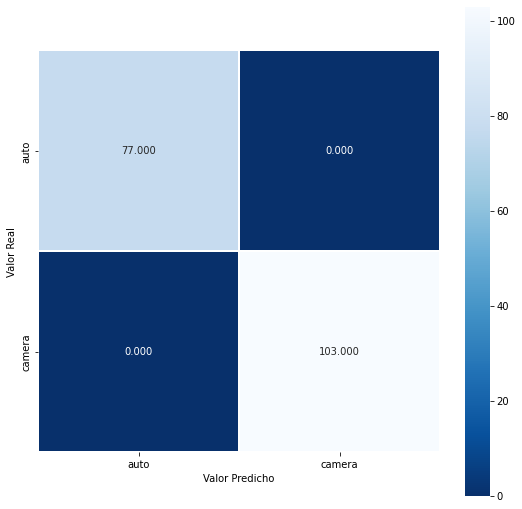

In [37]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels = ["auto", "camera"], xticklabels = ["auto", "camera"]);
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');

In [38]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_measure = 2 /(1/precision+1/recall)
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F-measure = " + str(F_measure))

Precision = 1.0
Recall = 1.0
F-measure = 1.0


## 3.2 TFIDF + N-grams

### 3.2.1 Feature selection

In [39]:
# Create feature and target variable for Classification problem
X_clf = cv_tfidf_ngrams

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

print(y_clf)

[0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0
 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0
 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1
 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0
 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0
 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0
 1 1 0 1 0 0 1 0 1 0 1 0 

In [40]:
X_clf_new=SelectKBest(score_func=chi2,k=int(X_clf.shape[1] * .3)).fit_transform(X_clf,y_clf) # k is the 30% of the features number

# Check the newly created variable shape
print(X_clf_new.shape)

(600, 102335)


### 3.2.2 Classification algorithm

In [41]:
X_clf_new = pd.DataFrame(X_clf_new)

x_features = list(X_clf_new.columns)
len(x_features)

102335

In [42]:
X = X_clf_new[x_features]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

#### 3.2.2.1 SVM

In [43]:
# Hyperparameter optimization
param_dist = {
              'kernel': ['linear', 'rbf'],
             }
SVM = GridSearchCV(estimator = svm.SVC(), param_grid = param_dist, 
                   cv = 2, n_jobs = -1) # SVM model definition

SVM.fit(X_train, y_train) # Training

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'kernel': ['linear', 'rbf']})

In [44]:
y_pred = SVM.predict(X_test) # Prediction

print(X_test)
print(y_pred)

       0         1       2       3       ...  102331  102332  102333  102334
110  0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0
419  0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0
565  0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0
77   0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0
181  0.021025  0.032363     0.0     0.0  ...     0.0     0.0     0.0     0.0
..        ...       ...     ...     ...  ...     ...     ...     ...     ...
54   0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0
493  0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0
46   0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0
93   0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0
264  0.000000  0.000000     0.0     0.0  ...     0.0     0.0     0.0     0.0

[180 rows x 102335 columns]
[1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 

For a correct result visualization, confusion matrix will be plotted. Also the *Precision*, *Recall* and *F-measure* will be calculated.




[[ 77   0]
 [  0 103]]


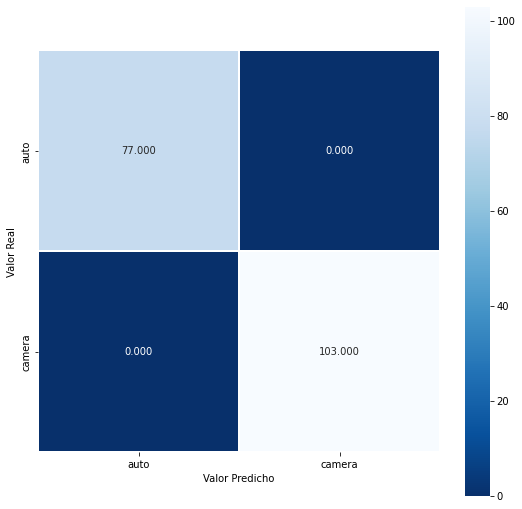

In [45]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels = ["auto", "camera"], xticklabels = ["auto", "camera"]);
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');

In [46]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_measure = 2 /(1/precision+1/recall)
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F-measure = " + str(F_measure))

Precision = 1.0
Recall = 1.0
F-measure = 1.0


#### 3.2.2.2 RandomForests

In [47]:
# Hyperparameter optimization
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_depth": [16, 15, 14, 13, 12, 11, 10, None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              }

In [48]:
regr = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_dist, 
                               n_iter = 5, cv = 5, random_state=0, n_jobs = -1)


# Fit the random search model
regr.fit(X = X_train, y = y_train)
regr.best_params_

{'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 32}

In [49]:
# Predict
y_pred = regr.predict(X = X_test)

For a correct result visualization, confusion matrix will be plotted. Also the *Precision*, *Recall* and *F-measure* will be calculated.


[[ 77   0]
 [  0 103]]


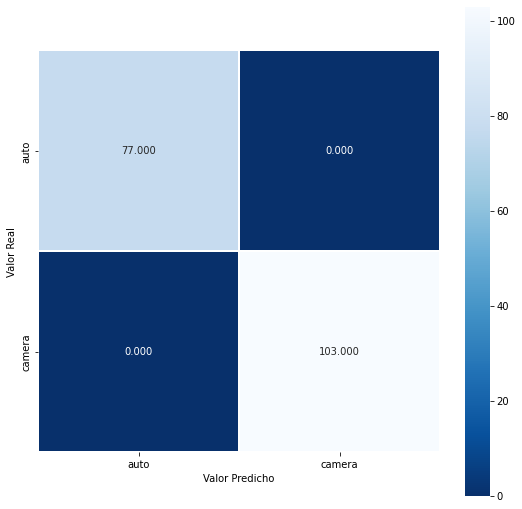

In [50]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels = ["auto", "camera"], xticklabels = ["auto", "camera"]);
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');

In [51]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_measure = 2 /(1/precision+1/recall)
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F-measure = " + str(F_measure))

Precision = 1.0
Recall = 1.0
F-measure = 1.0


## 3.3 TFIDF + N-grams + POS tagging

### 3.3.1 Feature selection

In [52]:
# Create feature and target variable for Classification problem
X_clf = cv_tfidf_ngrams_pos

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

print(y_clf)

[0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0
 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0
 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1
 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0
 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0
 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0
 1 1 0 1 0 0 1 0 1 0 1 0 

In [53]:
X_clf_new=SelectKBest(score_func=chi2,k=int(X_clf.shape[1] * .3)).fit_transform(X_clf,y_clf) # k is the 30% of the features number

# Check the newly created variable shape
print(X_clf_new.shape)

(600, 114134)


### 3.3.2 Classification algorithm

In [54]:
X_clf_new = pd.DataFrame(X_clf_new)

x_features = list(X_clf_new.columns)
len(x_features)

114134

In [55]:
X = X_clf_new[x_features]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

#### 3.3.2.1 SVM

In [56]:
# Hyperparameter optimization
param_dist = {
              'kernel': ['linear', 'rbf'],
             }
SVM = GridSearchCV(estimator = svm.SVC(), param_grid = param_dist, 
                   cv = 2, n_jobs = -1) # SVM model definition

SVM.fit(X_train, y_train) # Training

GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'kernel': ['linear', 'rbf']})

In [57]:
y_pred = SVM.predict(X_test) # Prediction

print(X_test)
print(y_pred)

       0       1       2       3       ...  114130  114131  114132  114133
110  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
419  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
565  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
77   0.013034     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
181  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
..        ...     ...     ...     ...  ...     ...     ...     ...     ...
54   0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
493  0.008305     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
46   0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
93   0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
264  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0

[180 rows x 114134 columns]
[1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 

For a correct result visualization, confusion matrix will be plotted. Also the *Precision*, *Recall* and *F-measure* will be calculated.




[[ 77   0]
 [  0 103]]


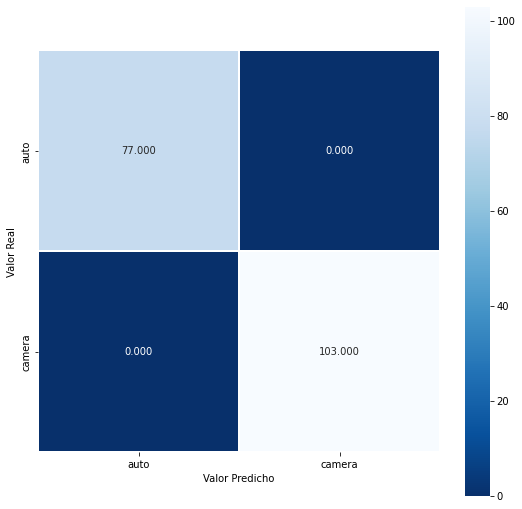

In [58]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels = ["auto", "camera"], xticklabels = ["auto", "camera"]);
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');

In [59]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_measure = 2 /(1/precision+1/recall)
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F-measure = " + str(F_measure))

Precision = 1.0
Recall = 1.0
F-measure = 1.0


#### 3.3.2.2 RandomForests

In [60]:
# Hyperparameter optimization
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_depth": [16, 15, 14, 13, 12, 11, 10, None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              }

In [61]:
regr = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_dist, 
                               n_iter = 5, cv = 5, random_state=0, n_jobs = -1)


# Fit the random search model
regr.fit(X = X_train, y = y_train)
regr.best_params_

{'max_depth': 12, 'min_samples_split': 49, 'n_estimators': 128}

In [62]:
# Predict
y_pred = regr.predict(X = X_test)

For a correct result visualization, confusion matrix will be plotted. Also the *Precision*, *Recall* and *F-measure* will be calculated.


[[ 77   0]
 [  0 103]]


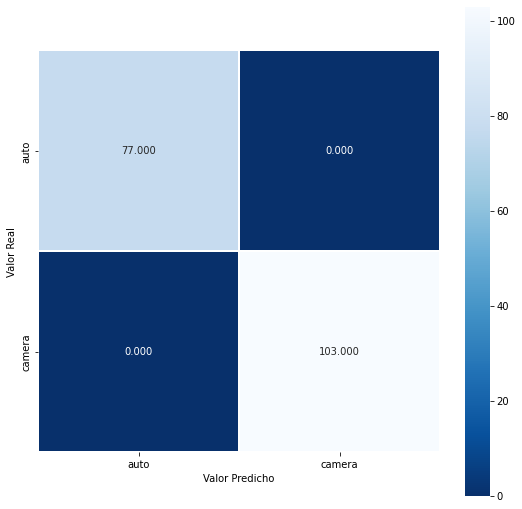

In [63]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels = ["auto", "camera"], xticklabels = ["auto", "camera"]);
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');

In [64]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_measure = 2 /(1/precision+1/recall)
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F-measure = " + str(F_measure))

Precision = 1.0
Recall = 1.0
F-measure = 1.0


## 3.4 TFIDF + N-grams + POS tagging + other features

### 3.4.1 Feature selection

In [65]:
# Create feature and target variable for Classification problem
X_clf = cv_tfidf_ngrams_pos_other

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

print(y_clf)

[0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0
 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0
 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1
 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0
 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0
 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0
 1 1 0 1 0 0 1 0 1 0 1 0 

In [66]:
X_clf_new=SelectKBest(score_func=chi2,k=int(X_clf.shape[1] * .3)).fit_transform(X_clf,y_clf) # k is the 30% of the features number

# Check the newly created variable shape
print(X_clf_new.shape)

(600, 114134)


### 3.4.2 Classification algorithm

In [67]:
X_clf_new = pd.DataFrame(X_clf_new)

x_features = list(X_clf_new.columns)
len(x_features)

114134

In [68]:
X = X_clf_new[x_features]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

#### 3.4.2.1 SVM

In [69]:
# Hyperparameter optimization
param_dist = {
              'kernel': ['linear', 'rbf'],
             }
SVM = GridSearchCV(estimator = svm.SVC(), param_grid = param_dist, 
                   cv = 2, n_jobs = -1) # SVM model definition

SVM.fit(X_train, y_train) # Training

GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'kernel': ['linear', 'rbf']})

In [70]:
y_pred = SVM.predict(X_test) # Prediction

print(X_test)
print(y_pred)

       0       1       2       3       ...  114130  114131  114132  114133
110  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0   757.0
419  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0   226.0
565  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0    78.0
77   0.013034     0.0     0.0     0.0  ...     0.0     0.0     0.0   445.0
181  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0   412.0
..        ...     ...     ...     ...  ...     ...     ...     ...     ...
54   0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0   838.0
493  0.008305     0.0     0.0     0.0  ...     0.0     0.0     0.0   933.0
46   0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0   310.0
93   0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0   118.0
264  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0   153.0

[180 rows x 114134 columns]
[1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 

For a correct result visualization, confusion matrix will be plotted. Also the *Precision*, *Recall* and *F-measure* will be calculated.




[[ 76   1]
 [  0 103]]


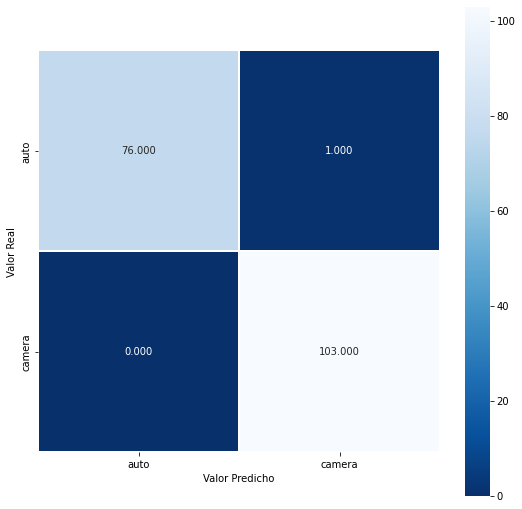

In [71]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels = ["auto", "camera"], xticklabels = ["auto", "camera"]);
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');

In [72]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_measure = 2 /(1/precision+1/recall)
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F-measure = " + str(F_measure))

Precision = 0.987012987012987
Recall = 1.0
F-measure = 0.9934640522875817


#### 3.4.2.2 RandomForests

In [73]:
# Hyperparameter optimization
param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
              "max_depth": [16, 15, 14, 13, 12, 11, 10, None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              }

In [74]:
regr = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_dist, 
                               n_iter = 5, cv = 5, random_state=0, n_jobs = -1)


# Fit the random search model
regr.fit(X = X_train, y = y_train)
regr.best_params_

{'max_depth': 12, 'min_samples_split': 49, 'n_estimators': 128}

In [75]:
# Predict
y_pred = regr.predict(X = X_test)

For a correct result visualization, confusion matrix will be plotted. Also the *Precision*, *Recall* and *F-measure* will be calculated.


[[ 77   0]
 [  0 103]]


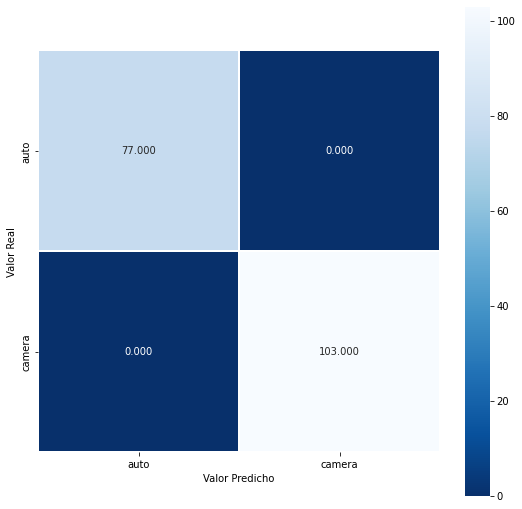

In [76]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels = ["auto", "camera"], xticklabels = ["auto", "camera"]);
plt.ylabel('Valor Real');
plt.xlabel('Valor Predicho');

In [77]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_measure = 2 /(1/precision+1/recall)
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F-measure = " + str(F_measure))

Precision = 1.0
Recall = 1.0
F-measure = 1.0
